# Calculating the difference in mean state
This notebook focuses on the changes to the mean state of the future projectd in our model

In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.15/20607/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [4]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [5]:
# files stored in Guillaumes East Coast Low (ECL) directory
mean_dir = '/g/data1a/e14/gs9353/POST-PROCESS/ECLs/'
# We slice away the troublesome regions. Also fix nav_lon
mean_file = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_mean.nc').isel(x = slice(5,-5), y = slice(5,-50))
mean_file['nav_lon'] = mean_file['nav_lon'] % 360

# Do the same for EKE
EKE = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_Eddy_Kinetic_Energy.nc').isel(x = slice(5,-5), y = slice(5,-50))
EKE['nav_lon'] = EKE['nav_lon'] % 360
'''
I think Guillaume has changed the file name for the sst stuff. Yup he has - section needs to stay updated
# Loading sst
cfg = 'present_vs_future.ini'
# mld = Mixed Layer Depth
sst = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['tos']
''';

In [6]:
seas_file = xr.open_zarr(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_seasonal_cycle.zarr')
seas_file['nav_lon'] = seas_file['nav_lon'] % 360 

## Eddy Kinetic Energy

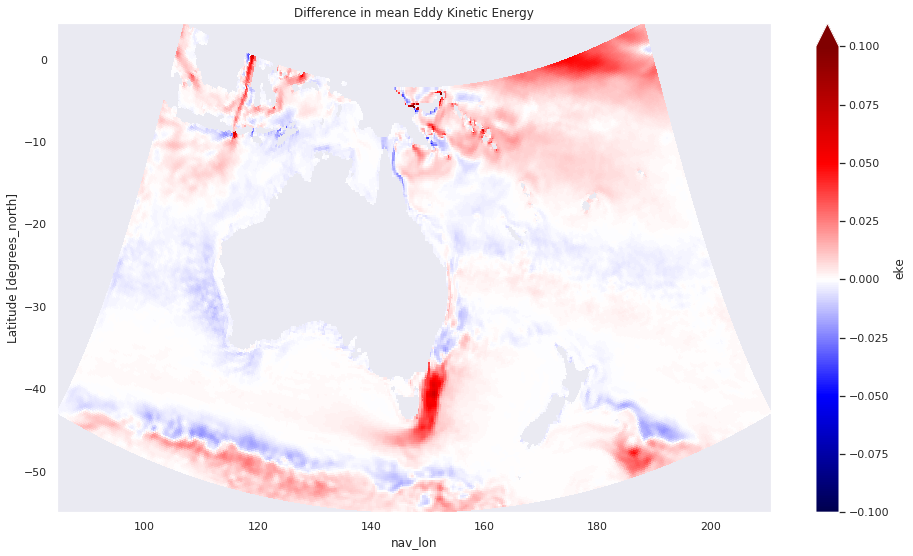

In [7]:
(EKE.sel(simulation = 'Future')['eke'] - EKE.sel(simulation = 'Present')['eke']).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', vmin = -0.1, vmax = 0.1);
plt.title('Difference in mean Eddy Kinetic Energy');

## SST  

In [8]:
# Only have to do this because Guillaume has moved the normal file
sstPast = xr.open_zarr('/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_v1/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Present')
sstFut = xr.open_zarr('/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_ALL/cordex24-BMJv2_BILAP_ALL_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Future')

PermissionError: [Errno 13] Permission denied: '/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_v1/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr/.zgroup'

In [31]:
sst_diff = sstFut - sstPast
# Calculating the difference in max SSTA for each grid cell
max_sst_diff = sst_diff.isel(x = slice(5,-5), y = slice(5,-50)).max('time_counter').compute()
max_sst_diff['nav_lon'] = max_sst_diff['nav_lon'] % 360 
# Calculating the difference in mean SSTA for each grid cell
mean_sst = mean_file['tos']
mean_sst_diff = mean_sst.sel(simulation = 'Future') - mean_sst.sel(simulation = 'Present') 

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


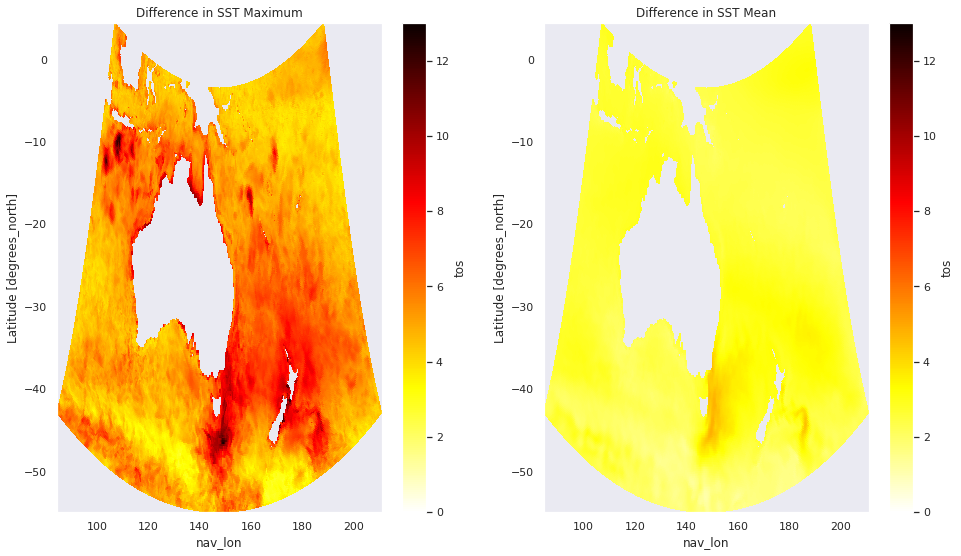

In [32]:
f, (ax1, ax2) = plt.subplots(1,2)
vmin, vmax = (0, 13) 

max_sst_diff.plot(cmap = 'hot_r', vmin = vmin, ax = ax1, x='nav_lon', y ='nav_lat', vmax = vmax)
mean_sst_diff.plot(cmap = 'hot_r', vmin = vmin, ax = ax2, x = 'nav_lon', y = 'nav_lat', vmax = vmax);

ax1.set_title('Difference in SST Maximum')
ax2.set_title('Difference in SST Mean');

## Mixed Layer Depth (MLD) 

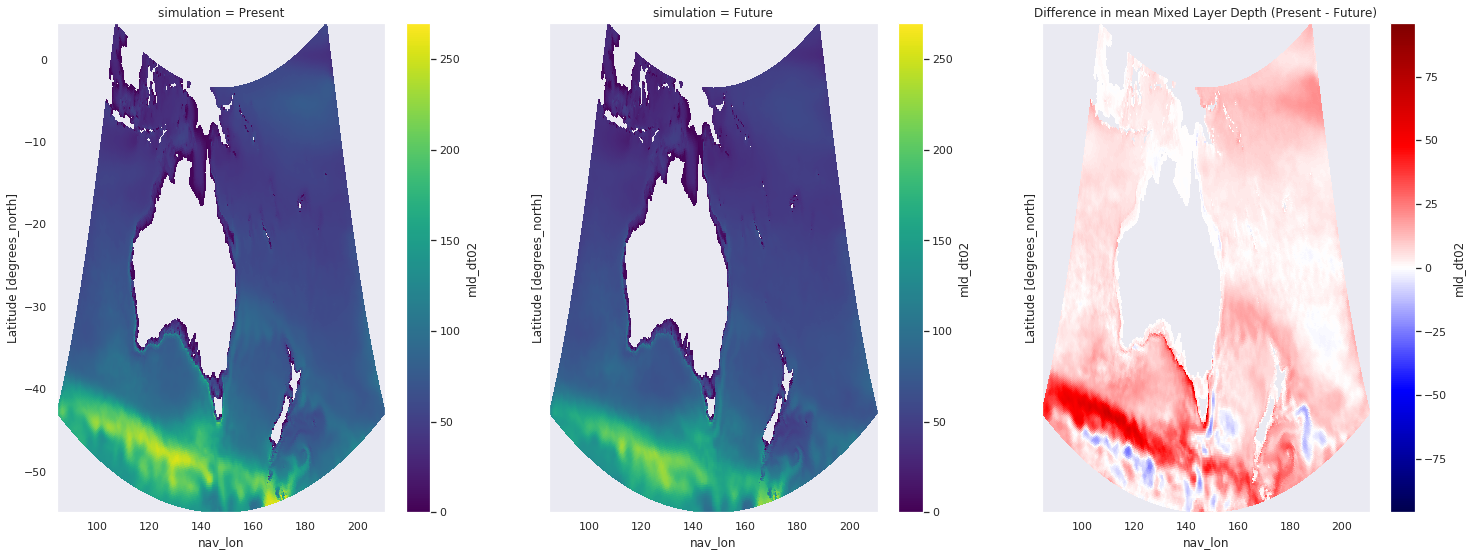

In [34]:
mld = mean_file['mld_dt02']
f, axes = plt.subplots(1,3, figsize = [25,9], sharey = True)
(vmin, vmax) = (0, 270)
mld.sel(simulation = 'Present').plot(x = 'nav_lon', y = 'nav_lat', ax = axes[0], vmin = vmin, vmax = vmax);
mld.sel(simulation = 'Future').plot(x = 'nav_lon', y = 'nav_lat', ax = axes[1], vmin = vmin, vmax = vmax);
(mld.sel(simulation = 'Present') - mld.sel(simulation = 'Future')).plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', ax = axes[2]);

axes[2].set_title('Difference in mean Mixed Layer Depth (Present - Future)');
# +ve means past deeper than future, -ve means future deeper than past
# We are expecting increased ocean stratification, so want +ve values

In [37]:
mld_seas = seas_file['mld_dt02']

In [38]:
mld_seas_past = mld_seas.sel(simulation = 'Present').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
mld_seas_fut = mld_seas.sel(simulation = 'Future').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
# Changes name of dayofyear coordinates to season names, and changes coordinate name to 'Season'
mld_seas_past['dayofyear_bins'] = ['Summer', 'Autumn', 'Winter', 'Spring']
mld_seas_past = mld_seas_past.rename({'dayofyear_bins' : 'season'}).isel(x = slice(5,-5), y = slice(5,-50))
mld_seas_fut['dayofyear_bins'] = ['Summer', 'Autumn', 'Winter', 'Spring']
mld_seas_fut = mld_seas_fut.rename({'dayofyear_bins' : 'season'}).isel(x = slice(5,-5), y = slice(5,-50))

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [39]:
mld_seas_diff = mld_seas_fut - mld_seas_past

In [64]:
# Attempt at p-values by season, but I need multiple values per season - Don't know how to get that
mld_pValue = [[[], []], [[], []], [[], []], [[], []]]
sig_mld = [[[], []], [[], []], [[], []], [[], []]]
for i in range(0,4):
    (t, mld_pValue[i]) = stats.ttest_rel(mld_seas_past.isel(season = i), mld_seas_fut.isel(season = i))
    sig_mld[i] = xr.where(mid_pValue[i] > 0.05, np.nan, mid_pValue[i]) 
'''
# One value for entire dataset - wrong 
t, mld_pValue = stats.ttest_rel(mld_seas_past, mld_seas_fut)
sig_mld = xr.where(mld_pValue > 0.05, np.nan, mld_pValue) 
''';

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


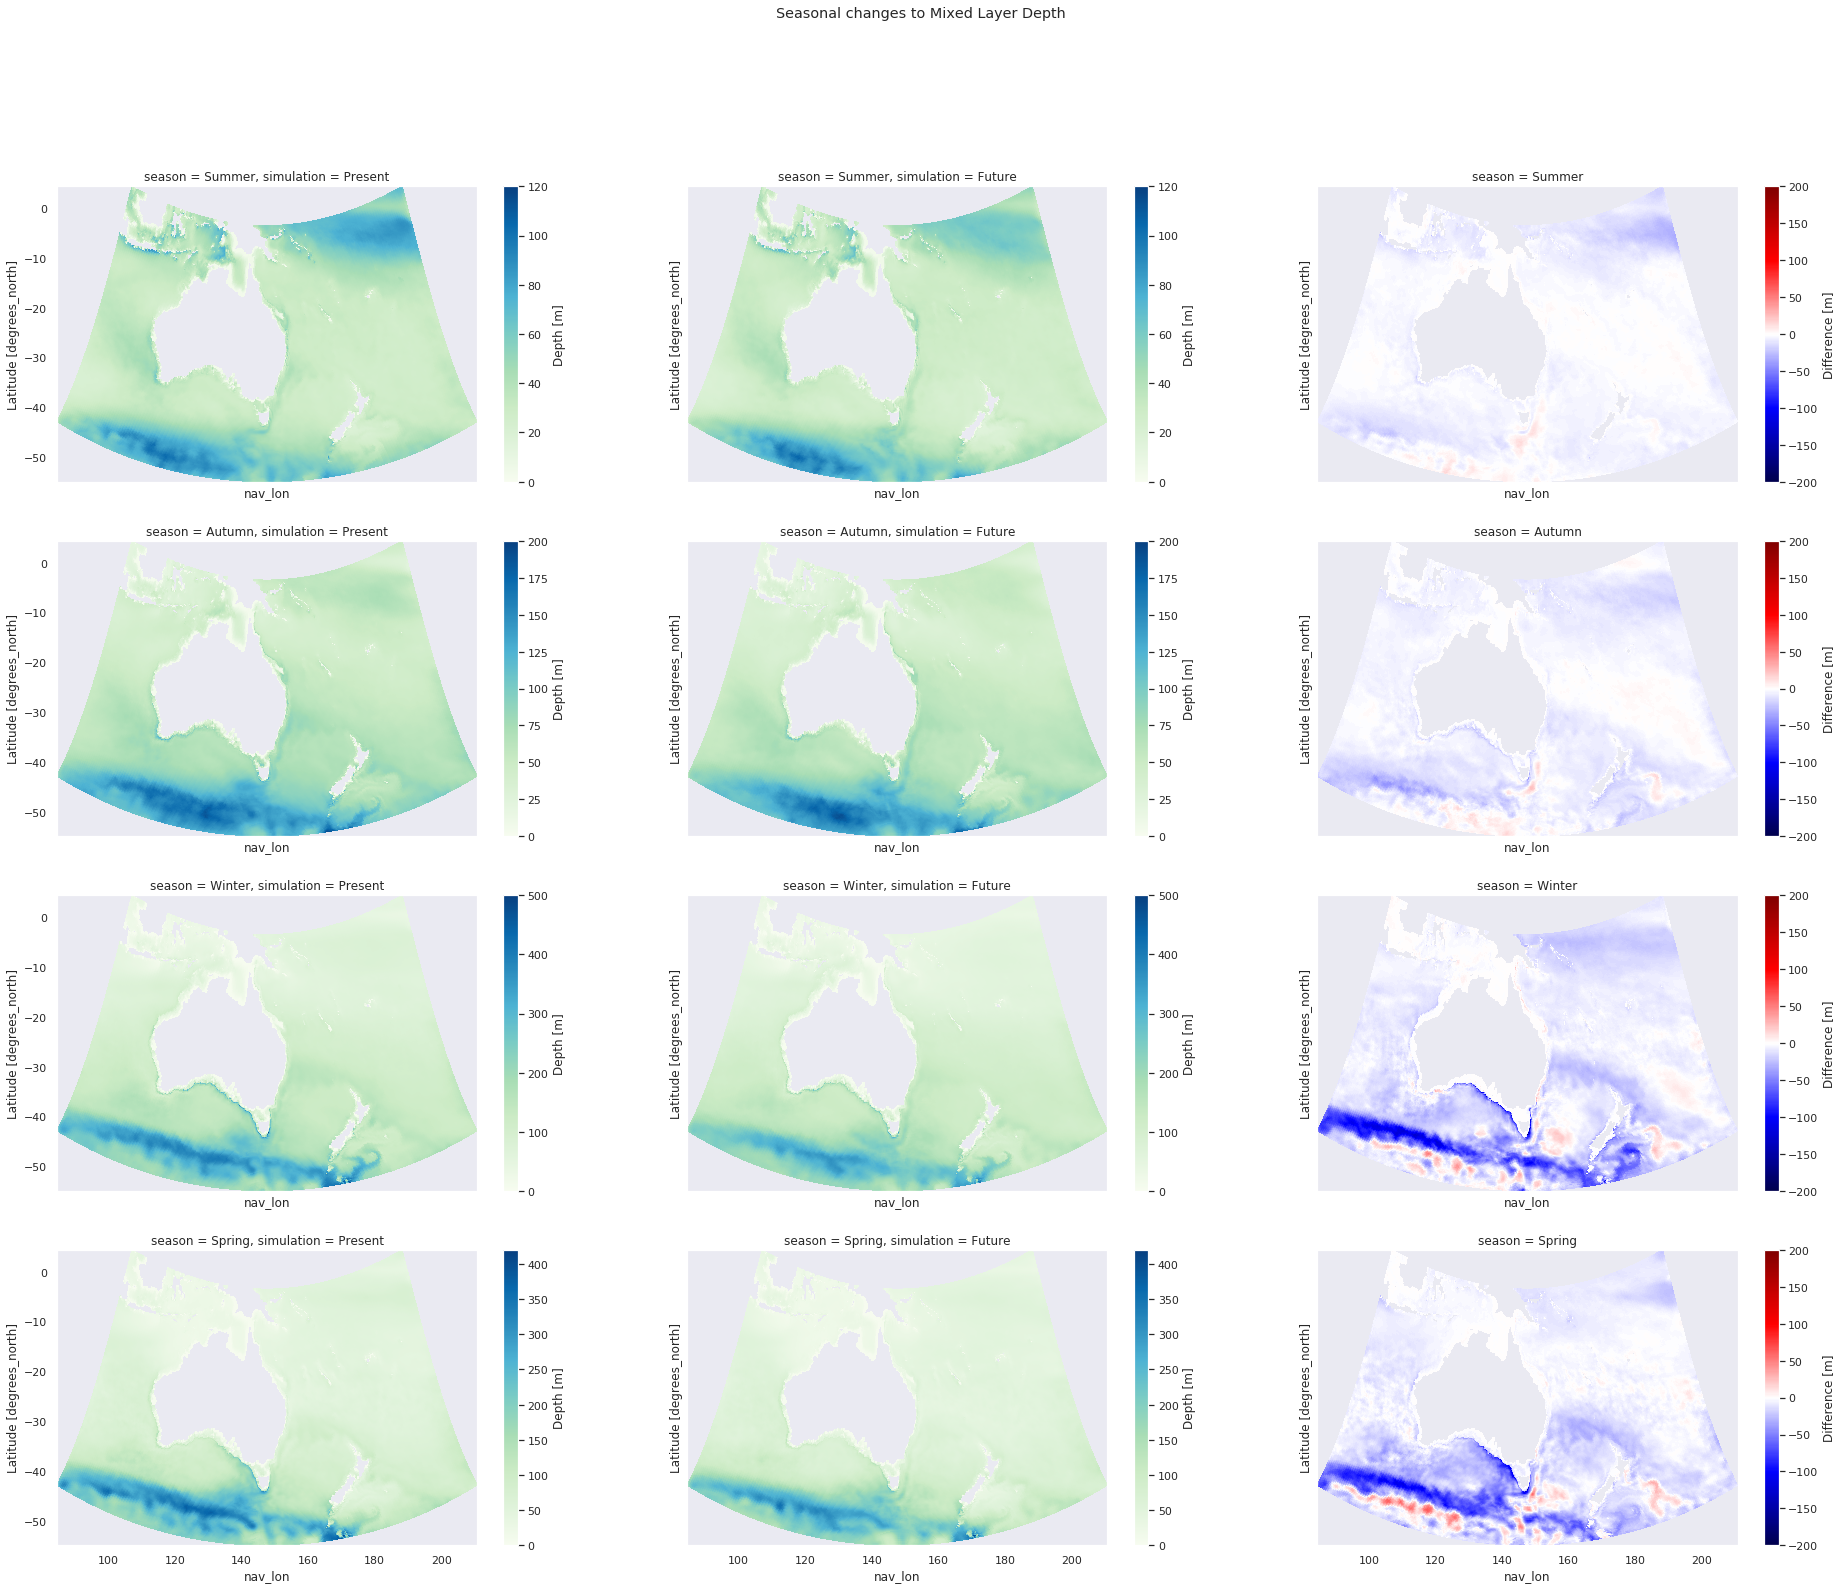

In [107]:
f, axes = plt.subplots(4,3, sharex = True, sharey = True,figsize = (32, 25))
f.suptitle('Seasonal changes to Mixed Layer Depth')
# Different vmaxs for different seasons
vmax = [120, 200, 500, 420]
vmin1, vmax1 = (-200, 200)
i = 0
for ax in axes:
    mld_seas_past.isel(season = i).plot(x='nav_lon', y ='nav_lat', ax = ax[0], vmin = 0, vmax = vmax[i], cbar_kwargs = {'label' : 'Depth [m]'}, cmap = 'GnBu');
    mld_seas_fut.isel(season = i).plot(x='nav_lon', y ='nav_lat', ax = ax[1], vmin = 0, vmax = vmax[i], cbar_kwargs = {'label' : 'Depth [m]'}, cmap = 'GnBu');
    mld_seas_diff.isel(season = i).plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax[2], vmin = vmin1, vmax = vmax1, cbar_kwargs = {'label' : 'Difference [m]'});
    #ax[2].contourf(mld_seas_diff['nav_lon'], mld_seas_diff['nav_lat'], sig_mld, levels = [0,0.05], hatches=['\/'], colors = 'none');
    # Need to perform a t-test for each season - not sure how to do it right now
    i += 1 
    
# Looking for positve values (implies future shallower than past)
# Need to superimpose t-test values over the difference plot before saving it. ALmost there!
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/mld_seasons.png')

## Plotted Together 

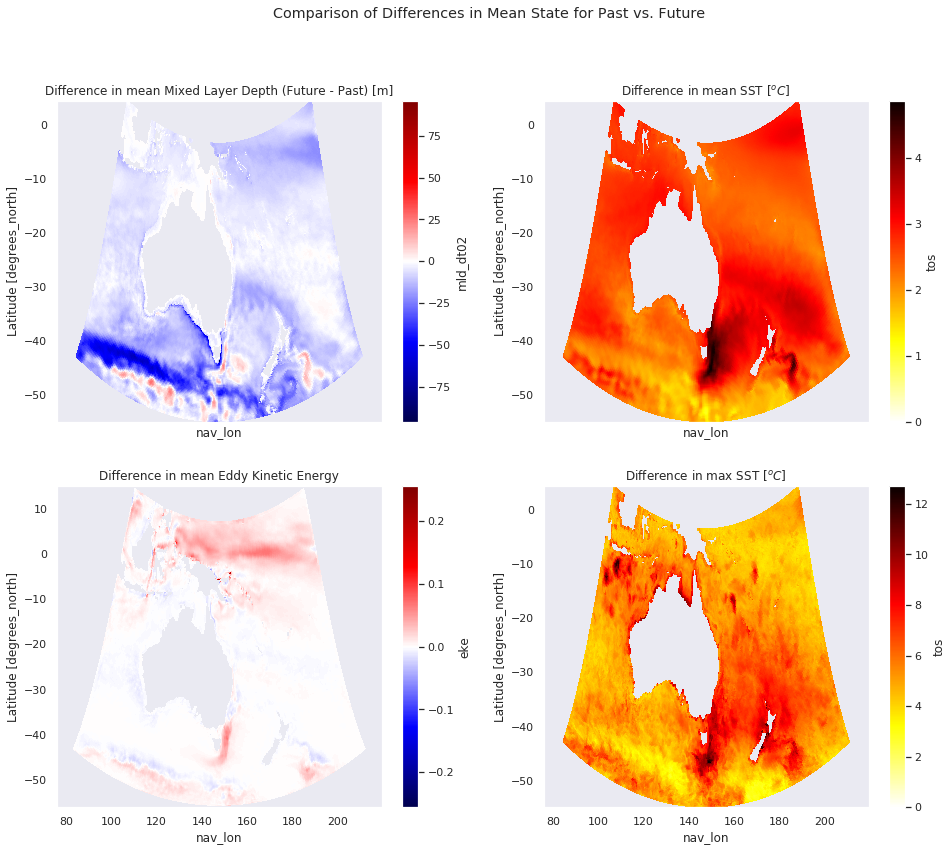

In [513]:
f, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, sharex = True, figsize = (16, 13))
f.suptitle('Comparison of Differences in Mean State for Past vs. Future');

(mld.sel(simulation = 'Future') - mld.sel(simulation = 'Present')).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax11)
(EKE.sel(simulation = 'Future')['eke'] - EKE.sel(simulation = 'Present')['eke']).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax21)
max_sst_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax22, vmin = 0)
mean_sst_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax12, vmin = 0)


ax11.set_title('Difference in mean Mixed Layer Depth (Future - Past) [m]')
ax22.set_title('Difference in max SST [$^oC$]')
ax21.set_title('Difference in mean Eddy Kinetic Energy')
ax12.set_title('Difference in mean SST [$^oC$]');
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/diff_in_mean_states.png')

### Mean SST by season

In [515]:
sst_seas = seas_file['tos']

In [516]:
sst_seas_past = sst_seas.sel(simulation = 'Present').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
sst_seas_fut = sst_seas.sel(simulation = 'Future').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [533]:
sst_seas_diff = sst_seas_fut - sst_seas_past
sst_seas_diff = sst_seas_diff.isel(x = slice(5,-5), y = slice(5,-50))

seasons = {0:'Summer', 1:'Autumn', 2:'Winter', 3:'Spring'}

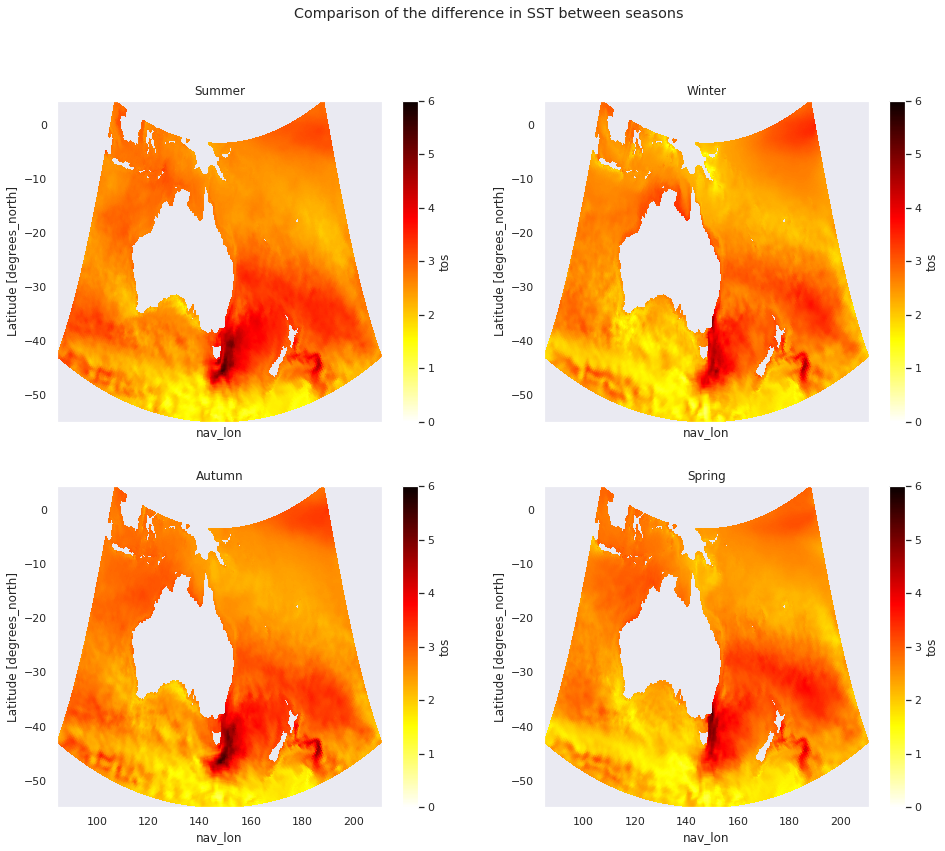

In [552]:
f, axes = plt.subplots(2,2, sharex = True, figsize = (16, 13))
# So that our plots are in line with the others: (swaps winter and autumn axes)
temp = axes[1,0]
axes[1,0] = axes[0,1]
axes[0,1] = temp
f.suptitle('Comparison of the difference in SST between seasons')

vmin, vmax = (0, 6)
i = 0
for ax in axes.flat:
    sst_seas_diff.isel(dayofyear_bins = i).plot(cmap = 'hot_r', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
# Looking for positve values (implies future shallower than past)
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/sst_seasons.png')

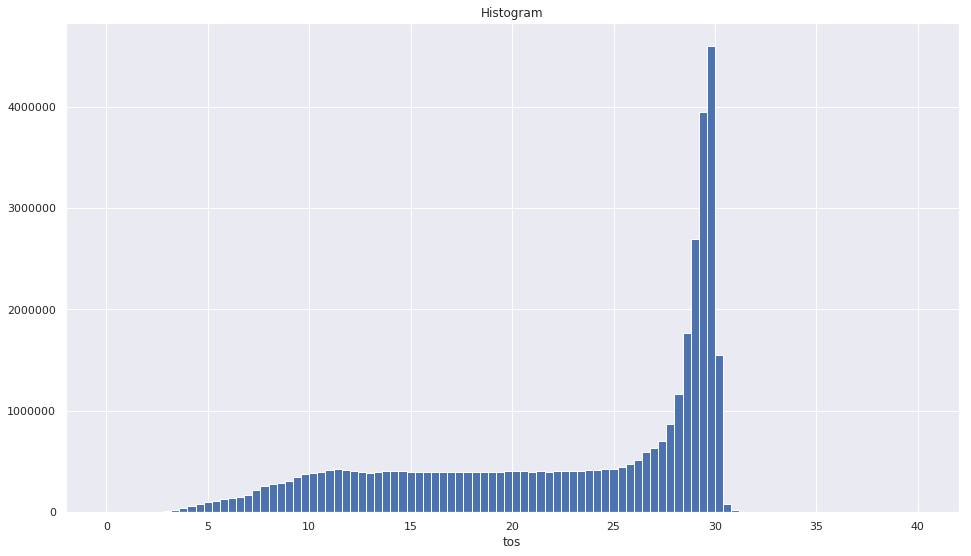

In [645]:
sst_seas.sel(simulation = 'Present').plot.hist(bins = np.linspace(0,40, 101));

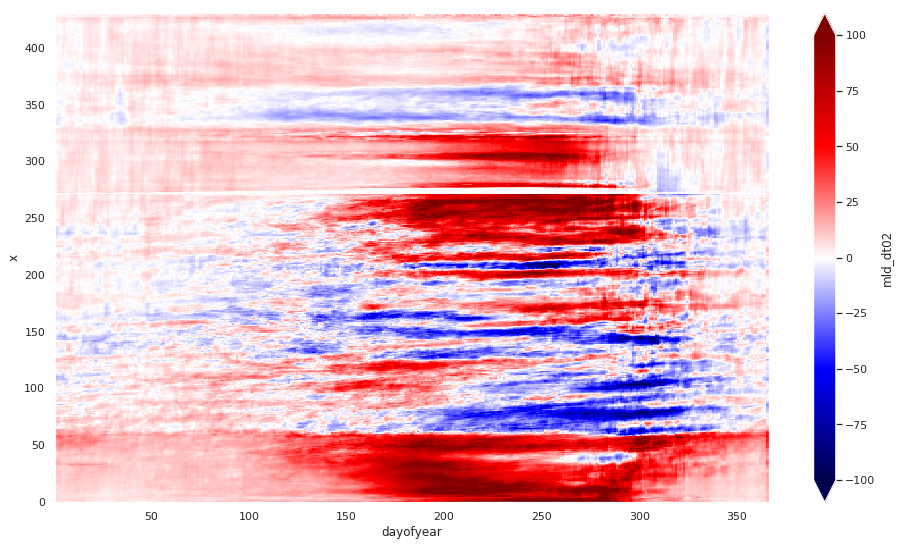

In [331]:
vmin, vmax = (-100, 100)
index = 20
(mld_seas.sel(simulation = 'Present') - mld_seas.sel(simulation = 'Future')).isel(y = index).transpose().plot(vmin = vmin, vmax = vmax, cmap = 'seismic');

# Random Stuff 

In [44]:
xr.open_zarr(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_seasonal_cycle.zarr')

<xarray.Dataset>
Dimensions:     (dayofyear: 366, simulation: 3, x: 431, y: 289)
Coordinates:
  * dayofyear   (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
    nav_lat     (y, x) float32 dask.array<shape=(289, 431), chunksize=(289, 431)>
    nav_lon     (y, x) float32 dask.array<shape=(289, 431), chunksize=(289, 431)>
  * simulation  (simulation) object 'Present' 'No Current Feedback' 'Future'
Dimensions without coordinates: x, y
Data variables:
    20d         (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    blt         (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    depti       (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    mld_dt02    (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    mldkz5      (dayofyear, simulation, y, x) float32 da